# EN4353 - Radar and Navigation Assignment 01 

160450j

M.N.M.Nusri

### Importing the necessory libraries

In [1]:
import pandas as pd
import numpy as np
from itertools import chain
import matplotlib.pyplot as plt
import math
import seaborn as sns

### Load the .csv dataset.

Here dataset should be in the same directory. if not correct path should be given.

**datasets should be of size 18000**

In [2]:
df=pd.read_csv('raw_data3.csv',header=None)

# Parameters
For threshold detection a window size of 21 was chosen on the original samples:

**window_size=21**


The signal was down-sampled  to fit into 30 range slots:

**ncols=30**


A guard band of 4 is chosen:

**guard=4**


for noise thresholding values of **k=1.5** and **sigma=1** were chosen

Pulse Repetition  Frequency: **fr = 1800 Hz**

Initial Sampling Frequency **Fs_orig = 1080kHz**

Speed of Light $C=3\times10^{8}ms^{-1}$

Speed of rotation of the radar $revol\: speed = 12 \:revols.\: per\: minute$

Initial azimuth angle $\theta_{init} = 0^0$

Horizontal Beam Width $\theta_H = 2^0$


In [3]:
window_size=21
ncols=30
guard=4
fr = 1800 # pulse repitition freq
Fs_orig = 1080*1000 #original sampling frequency of  1080kHz

k=1.5
sigma=1
middle=window_size//2

C = 3e8
rev_speed = 12
theta_init = 0
theta_h = 2

ini_list=df.values.tolist()
lst = list(chain.from_iterable(ini_list))    # flatten the list
len(lst)

18000

## sampling, calculating the noise average and thresholding for target detection


### Down sampling
1 pulse contains 30 bins. Therefore required sampling frequency:

    Fs=NFr 

    Fs=30x1800
      = 54KHz
$T_s = \frac{1}{F_s} = 18.52\mu s$

$T_{sampled} = \frac{n_{samples}}{fs} = \frac{18000}{1080000} = \frac{1}{60} s$

$\theta_{revolved} = \frac{revol\ speed \times T_{sampled} \times 360^{\circ}}{60} = 1.2^{\circ}$

$echoes\ per\ \theta_H = \frac{\theta_H \times f_r}{6 \times revol\ speed} = 50$

$echoes\ for\ 1.2^{\circ} = \frac{echoes\ per\ \theta_H \times 1.2^{\circ}}{\theta_H} = 30$

Therefore dimensions of the data matrix would be $(echoes\ for\ 1.2^{\circ}\times N)= 30\times30$

we need to downsample 1080KHz raw data into 54KHz. Therefore sampling interval:

    1080/54= 20

### calculating the noise average
to calculate the noise average a window of size 21 is selected. a guard band of 4 from either side of the ith sample was introduced as the energy of a target echo may affect the adjacent samples and considering them as noise is not be correct.

Therefore there are 6 samples in the past video and 6 samples in the future video.

>$(V_n)_{avg} = \frac{\sum_{i=5}^{10} (past video) + \sum_{i=5}^{10} (future video)}{12}$

![title](1.png)
<!-- ![Image](https://drive.google.com/file/d/1Nx7Cx4EaY1B7QpbwtWny1NWuQvKFPjX3/view?usp=sharing) -->

### Thresholding
Thresold valoue Vth for a range slot:

**V_TH = (Vn)Avg + k σn**




for target detection, data array "target_lst" was created by identifying values greater  than the threshold as 1 and else 0. 

$If\:\: V_{k}>V_{TH} \:\: then \:V_{k} =1 \:otherwise \:0$


for cloud detection we further processed the data array "thr_lst". this thr_lst was created by identifying values greater  than the threshold as that same value and else 0.

$If\:\: V_{k}>V_{TH} \:\: then \:V_{k} =V_{k} \:otherwise \:0$

In [4]:
Fs = ncols*fr
Ts = Fs_orig / Fs

In [5]:
thr_lst=[] 
target_lst=[] 
v0_avg=sum(lst[1+guard:middle+1])/(middle-guard)
v0_th=v0_avg+k*sigma
if lst[0]>=v0_th:
    thr_lst.append(lst[0])
    target_lst.append(1)
else:
    thr_lst.append(0)
    target_lst.append(0)
#---------------------

sampled=[]
sampled.append(lst[0])

for i in range(len(lst)-window_size):
    window=lst[i:i+window_size]

    temp=sum(window[:(middle-guard)])+sum(window[(middle+guard+1):])
    vn_avg=temp/(2*(middle-guard))
    v_th=vn_avg+k*sigma

    if (i+middle+1)%20==0:
        sampled.append(lst[i+middle])
        if lst[i+middle]>=v_th :
            thr_lst.append(lst[i+middle])
            target_lst.append(1)

        else:
            thr_lst.append(0)
            target_lst.append(0)

    
    
    

In [6]:
target_lst=np.array(target_lst,np.float64)
target_lst=np.reshape(target_lst, (-1, ncols)) # reshape in to 30X30 matrix

A = np.array(thr_lst,np.float64)
B = np.reshape(A, (-1, ncols)) #reshape in to 30X30 matrix

## Post detection integration
If count > 0.5[Expected echoes per target per scan]

we consider there is a target in that range slot.

Here targets are indicated by "0.5" values

- - - - - 
There is a target at 28 th slot


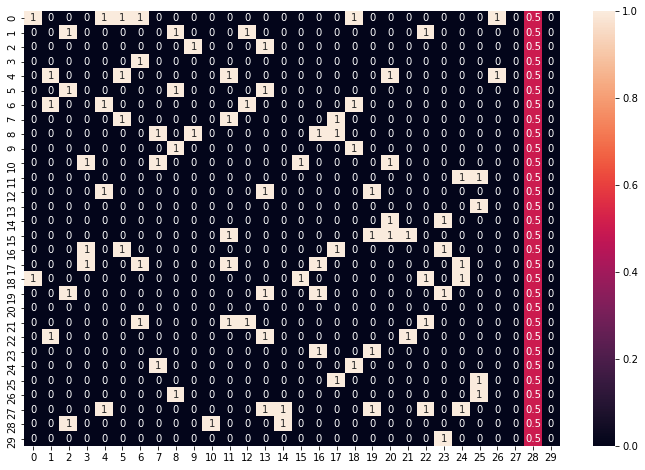

In [7]:
def detect_targets(img):
    target=[]
    xshape,yshape=img.shape
    for i in range(xshape):
        coloumn=img[0:yshape,i]
        if sum(coloumn)>=yshape*0.5:
            img[0:yshape,i]=0.5
            target.append(i)
            
    return img,target

target_img,targets=detect_targets(target_lst)
plt.figure(figsize = (12,8))
ax = sns.heatmap(target_img,annot=True)

if len(targets)>0:
    for target in targets:
        print("- - - - - ")
        print("There is a target at %d th slot"%target)
else:
    print("No target found")

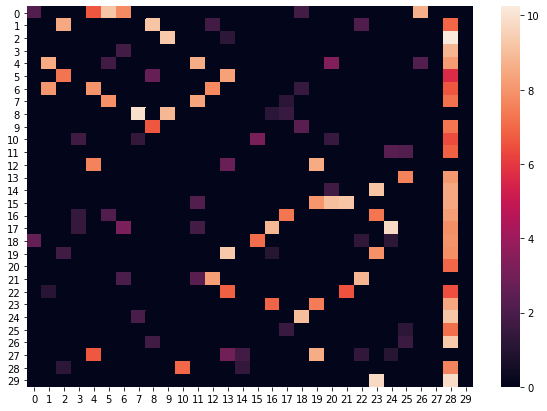

In [8]:
plt.figure(figsize = (10,7))
ax = sns.heatmap(B)

## Cloud detection
#### Cloud detection: step1
Due to the high noise present in the data matrix, further processing was needed. 
to remove more noise, values less than 6 were filtered out.

$If\:\: V_{k}>6 \:\: then \:V_{k} =V_{k} \:otherwise \:0$

as we have already detected the targets, targets were also filtered out for ease of cloud detection. Here values in the column corresponding to the target were made 0.

Then the rest of the non-zero values were mapped to 1 and 0





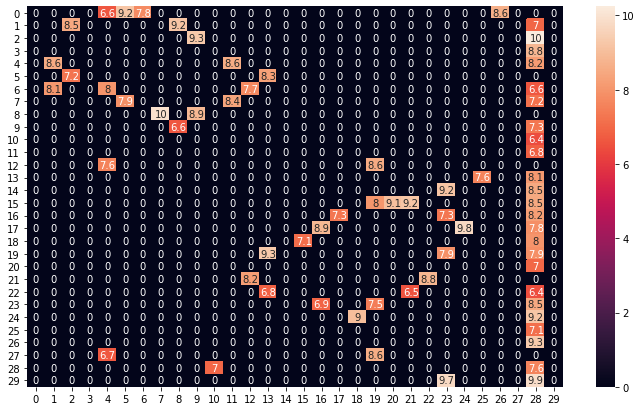

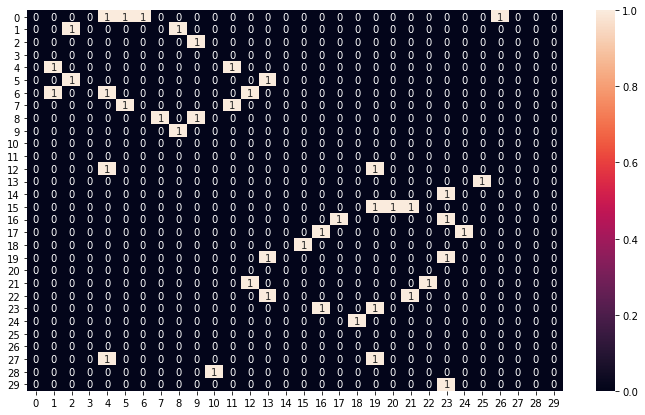

In [9]:
thresh6= np.where(B>6,B,0)
plt.figure(figsize = (12,7))
ax = sns.heatmap(thresh6,annot=True)
plt.show()


#Hide the targets temperoraly
__,yshape=thresh6.shape
for target in targets:
    thresh6[0:yshape,target]=0

thresh6= np.where(thresh6>0,1,0)
    
  
plt.figure(figsize = (12,7))    
ax = sns.heatmap(thresh6,annot=True)

#### Cloud detection: step2
**Filtering**

a kernel of 5X5 was used to filter out the remaining noise. Here if the value received after multiplying the kernel with a 5x5 area of the matrix is less than 1, that center value was identified as noise and filtered out.

Here a padding of 2 was used in the convolution

Kernal used:

                      [[1,1,1,1,1],
                       [1,1,1,1,1],
                       [1,1,0,1,1],
                       [1,1,1,1,1],
                       [1,1,1,1,1]]

In [10]:
def convolve2D(image, kernel, padding=0, strides=1):
    # Cross Correlation
    kernel = np.flipud(np.fliplr(kernel))

    # Gather Shapes of Kernel + Image + Padding
    xKernShape = kernel.shape[0]
    yKernShape = kernel.shape[1]
    xImgShape = image.shape[0]
    yImgShape = image.shape[1]

    # Shape of Output Convolution
    xOutput = int(((xImgShape - xKernShape + 2 * padding) / strides) + 1)
    yOutput = int(((yImgShape - yKernShape + 2 * padding) / strides) + 1)
    output = np.zeros((xOutput, yOutput))

    # Apply Equal Padding to All Sides
    if padding != 0:
        imagePadded = np.zeros((image.shape[0] + padding*2, image.shape[1] + padding*2))
        imagePadded[int(padding):int(-1 * padding), int(padding):int(-1 * padding)] = image

    else:
        imagePadded = image

    # Iterate through image
    for y in range(imagePadded.shape[1]):
        # Exit Convolution
        if y > imagePadded.shape[1] - yKernShape:
            break
        # Only Convolve if y has gone down by the specified Strides
        if y % strides == 0:
            for x in range(imagePadded.shape[0]):
                # Go to next row once kernel is out of bounds
                if x > imagePadded.shape[0] - xKernShape:
                    break
                try:
                    # Only Convolve if x has moved by the specified Strides
                    if x % strides == 0:
                        val= (kernel * imagePadded[x: x + xKernShape, y: y + yKernShape]).sum()  
                        if val<1:
                            image[x-padding+xKernShape//2, y-padding+yKernShape//2] =0         
                except:
                    break
    return image


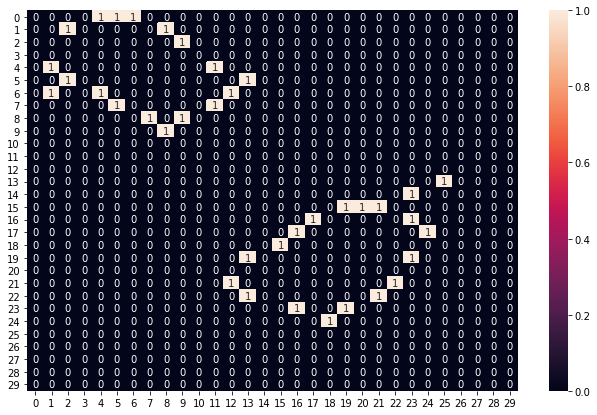

In [11]:
def noise_remove(img):    
    kernel = np.array([[1,1,1,1,1],
                       [1,1,1,1,1],
                       [1,1,0,1,1],
                       [1,1,1,1,1],
                       [1,1,1,1,1]])
    
    res=convolve2D(img,kernel,padding=2)
    return res

B_new=noise_remove(thresh6)

plt.figure(figsize = (11,7))
ax = sns.heatmap(B_new,annot=True)

#### Cloud detection: step3
##### Complete the missing values of the contour and filling the contour

**distance(x1,y1,x2,y2)** function

    given two cordinates x1,y1 and x2,y2 , returns the euclidean distance between the two points

**bresenham(x1,y1,x2,y2)** function

    this function implements the Bresenham’s Line Generation Algorithm. Given two coordinates x1,y1, and x2,y2 this algorithm determines the intermediate points which are needed to draw a line in between.

**fillgaps()** function

    in this function, we check the distance between a cell and every other cell. 

    if the distance is greater than or equal to 2 and less than or equal to Square root of 10, we check whether cell values are 1.
        2<= distance <= sqrt(10)

    if both cells have value of 1, we draw a line between those 2 cells, connecting them.

    to draw a line we use the bresenham algorithm and determine the intermediate points in between and value of those intermediate points were made 1. 

    after lines are drawn between the points of value 1, we get a connected as well as a filled cloud.


In [12]:
def distance(x1,y1,x2,y2):
    return ((y2-y1)**2 +(x2-x1)**2)**0.5
distance(1,1,2,2)

def bresenham(x1,y1,x2,y2):
    dx = x2 - x1
    dy = y2 - y1
    
#      Determine how steep the line is
    is_steep = abs(dy) > abs(dx)

    # Rotate line
    if is_steep:
        x1, y1 = y1, x1
        x2, y2 = y2, x2

    # Swap start and end points if necessary and store swap state
    swapped = False
    if x1 > x2:
        x1, x2 = x2, x1
        y1, y2 = y2, y1
        swapped = True

    # Recalculate differentials
    dx = x2 - x1
    dy = y2 - y1

    # Calculate error
    error = int(dx / 2.0)
    ystep = 1 if y1 < y2 else -1

    # Iterate over bounding box generating points between start and end
    y = y1
    points = []
    for x in range(x1, x2 + 1):
        coord = (y, x) if is_steep else (x, y)
        points.append(coord)
        error -= abs(dy)
        if error < 0:
            y += ystep
            error += dx

    # Reverse the list if the coordinates were swapped
    if swapped:
        points.reverse()
    return points

In [13]:
def fillgaps(img):
    count=0
    xshape,yshape=img.shape
    for i in range(yshape):
        for j in range(xshape):
            
            for k in range(yshape):
                for l in range(xshape):
                    
                    if 2<=distance(i,j,k,l)<=math.sqrt(10) and img[i,j]==1 and img[k,l]==1:
                        count+=1
                        points=bresenham(i, j, k, l)
                        for m in points:                            
                            xm,ym=m
                            img[xm,ym]=1                                            
    print(count)
    return img

newimg2=fillgaps(B_new.copy())


2257


## Visualizing the filled clouds and the targets.

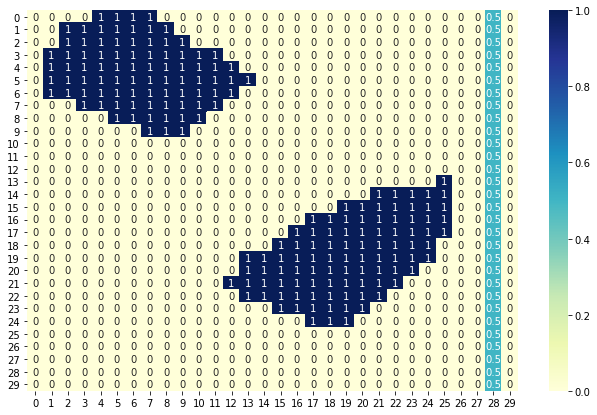

In [14]:
newimg3=newimg2.copy().astype(np.float64)
for target in targets:
    newimg3[0:yshape,target]=0.5

plt.figure(figsize = (11,7))
ax = sns.heatmap(newimg3,annot=True,cmap="YlGnBu")

#### Further noise removal
At this level, most of the time we get a noise free matrix that has only the filled clouds and the targets. 

To make the matrix completely noise free, **Opening** Morphological transformations can be performed. Then noise with single pixel width got removed.

Opening is just another name of erosion followed by dilation. 

we use a 3x3 kernel of ones for this.

(Before this stage OpenCV library was not used.)

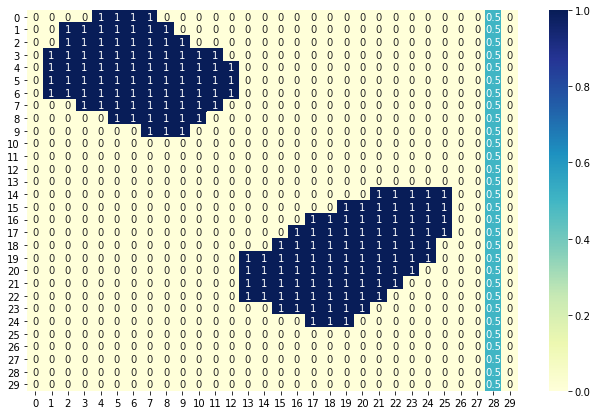

In [15]:
import cv2
kernel = np.ones((3,3),np.uint8)

data =  newimg2.copy() 
img = data.astype(np.uint8)

opening = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
opening=opening.astype(np.float64)
for target in targets:
    opening[0:yshape,target]=0.5

plt.figure(figsize = (11,7))
ax = sns.heatmap(opening,annot=True,cmap="YlGnBu")


## calculating the range of the objects:
For range and azimuth angle calculations:

$\Delta R = \frac{c \times T_{s}}{2} = 2778m$

$\omega_{radar} = \frac{revol\:speed\times2\pi}{60}$

following equations were used to calculate the range and azimuth angle of the target.

$
\\
\theta_k = \theta_{init} + \omega_{radar}\times \frac{1}{2\cdot F_s} \times bin\_number
\\
\\
R_k = \Delta R \times bin\_number 
\\
\\
p_k = (R_k, \theta_k)$

In [16]:

if len(targets) != 0:
    k = (rev_speed*360/60) * (1/(2*Fs))
#     print(k)
    azymuth = theta_init+ np.dot(np.add(targets,1),k)
#     print(azymuth)
    range_m = np.dot(C/(2*Fs),np.add(targets,1))
#     print(range_m)
    for i,(r, theta) in enumerate(zip(range_m, azymuth)):
        print(f'Distance to target {i+1} is: {r*1e-3:.3f}km' )
        print(f'Azumuth andgle: {theta:.3f}degrees')
        print("----------------------------------------")
else:
    print('No target detected')
    azymuth = []
    range_m = []  

Distance to target 1 is: 80.556km
Azumuth andgle: 0.019degrees
----------------------------------------
